In [1]:

pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\hp\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [3]:
# function to read raw text file
def read_text(deu):
        # open the file
        file = open(deu, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [4]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [5]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [6]:
deu_eng = deu_eng[:50000,:]

In [7]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn.', 'Wir sind falsch abgebogen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together.', 'Wir waren zusammen auf Reisen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together.', 'Wir sind zusammen gereist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [8]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn', 'Wir sind falsch abgebogen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together', 'Wir waren zusammen auf Reisen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together', 'Wir sind zusammen gereist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [9]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['we took a wrong turn', 'wir sind falsch abgebogen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['we traveled together', 'wir waren zusammen auf reisen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['we traveled together', 'wir sind zusammen gereist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


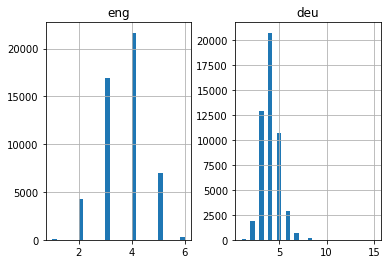

In [10]:
 # empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [11]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [12]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6152


In [13]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10112


In [14]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [15]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [16]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [17]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [18]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 169s 2s/step - loss: 4.2857 - val_loss: 2.7683

Epoch 00001: val_loss improved from inf to 2.76830, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 2/30
63/63 [==============================] - 141s 2s/step - loss: 2.7171 - val_loss: 2.6991

Epoch 00002: val_loss improved from 2.76830 to 2.69907, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 3/30
63/63 [==============================] - 136s 2s/step - loss: 2.5634 - val_loss: 2.5030

Epoch 00003: val_loss improved from 2.69907 to 2.50302, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 4/30
63/63 [==============================] - 135s 2s/step - loss: 2.3718 - val_loss: 2.4031

Epoch 00004: val_loss improved from 2.50302 to 2.40308, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 5/30
63/63 [==============================] - 149s 2s/step - loss: 2.2232 - val_loss: 2.2646

Epoch 00005: val_loss improved from 2.40308 to 2.26461, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 6/30
63/63 [==============================] - 152s 2s/step - loss: 2.0795 - val_loss: 2.1490

Epoch 00006: val_loss improved from 2.26461 to 2.14902, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 7/30
63/63 [==============================] - 194s 3s/step - loss: 1.9481 - val_loss: 2.0640

Epoch 00007: val_loss improved from 2.14902 to 2.06402, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 8/30
63/63 [==============================] - 1228s 20s/step - loss: 1.8341 - val_loss: 1.9883

Epoch 00008: val_loss improved from 2.06402 to 1.98834, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 9/30
63/63 [==============================] - 231s 4s/step - loss: 1.7279 - val_loss: 1.9107

Epoch 00009: val_loss improved from 1.98834 to 1.91065, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 10/30
63/63 [==============================] - 238s 4s/step - loss: 1.6338 - val_loss: 1.8383

Epoch 00010: val_loss improved from 1.91065 to 1.83827, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 11/30
63/63 [==============================] - 210s 3s/step - loss: 1.5227 - val_loss: 1.7796

Epoch 00011: val_loss improved from 1.83827 to 1.77960, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 12/30
63/63 [==============================] - 229s 4s/step - loss: 1.4444 - val_loss: 1.7034

Epoch 00012: val_loss improved from 1.77960 to 1.70336, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 13/30
63/63 [==============================] - 208s 3s/step - loss: 1.3390 - val_loss: 1.6477

Epoch 00013: val_loss improved from 1.70336 to 1.64771, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 14/30
63/63 [==============================] - 193s 3s/step - loss: 1.2556 - val_loss: 1.5985

Epoch 00014: val_loss improved from 1.64771 to 1.59854, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 15/30
63/63 [==============================] - 1040s 17s/step - loss: 1.1789 - val_loss: 1.5599

Epoch 00015: val_loss improved from 1.59854 to 1.55985, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 16/30
63/63 [==============================] - 230s 4s/step - loss: 1.1060 - val_loss: 1.5315

Epoch 00016: val_loss improved from 1.55985 to 1.53152, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 17/30
63/63 [==============================] - 219s 3s/step - loss: 1.0326 - val_loss: 1.4784

Epoch 00017: val_loss improved from 1.53152 to 1.47837, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 18/30
63/63 [==============================] - 217s 3s/step - loss: 0.9525 - val_loss: 1.4480

Epoch 00018: val_loss improved from 1.47837 to 1.44799, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 19/30
63/63 [==============================] - 233s 4s/step - loss: 0.8881 - val_loss: 1.4171

Epoch 00019: val_loss improved from 1.44799 to 1.41707, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 20/30
63/63 [==============================] - 171s 3s/step - loss: 0.8256 - val_loss: 1.4010

Epoch 00020: val_loss improved from 1.41707 to 1.40104, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 21/30
63/63 [==============================] - 187s 3s/step - loss: 0.7603 - val_loss: 1.3708

Epoch 00021: val_loss improved from 1.40104 to 1.37083, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 22/30
63/63 [==============================] - 190s 3s/step - loss: 0.6997 - val_loss: 1.3552

Epoch 00022: val_loss improved from 1.37083 to 1.35523, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 23/30
63/63 [==============================] - 168s 3s/step - loss: 0.6464 - val_loss: 1.3247

Epoch 00023: val_loss improved from 1.35523 to 1.32473, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 24/30
63/63 [==============================] - 172s 3s/step - loss: 0.5938 - val_loss: 1.3159

Epoch 00024: val_loss improved from 1.32473 to 1.31592, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 25/30
63/63 [==============================] - 157s 2s/step - loss: 0.5578 - val_loss: 1.2905

Epoch 00025: val_loss improved from 1.31592 to 1.29047, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 26/30
63/63 [==============================] - 147s 2s/step - loss: 0.5058 - val_loss: 1.2788

Epoch 00026: val_loss improved from 1.29047 to 1.27883, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 27/30
63/63 [==============================] - 159s 3s/step - loss: 0.4589 - val_loss: 1.2837

Epoch 00027: val_loss did not improve from 1.27883
Epoch 28/30
63/63 [==============================] - 146s 2s/step - loss: 0.4254 - val_loss: 1.2639

Epoch 00028: val_loss improved from 1.27883 to 1.26392, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 29/30
63/63 [==============================] - 151s 2s/step - loss: 0.3864 - val_loss: 1.2572

Epoch 00029: val_loss improved from 1.26392 to 1.25719, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 30/30
63/63 [==============================] - 152s 2s/step - loss: 0.3495 - val_loss: 1.2540

Epoch 00030: val_loss improved from 1.25719 to 1.25403, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


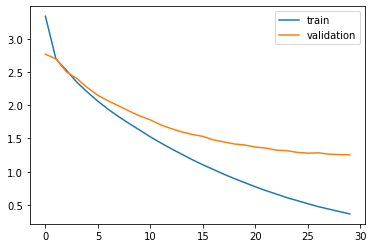

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [22]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [23]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [38]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [39]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [40]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
4494,he reads a good deal,he a lot
8414,its a nice party,its a nice party
9031,hes a frat boy,he is at guy
2604,thanks for saving me,thank for saving me
6386,thats weird,thats strange
4782,they arent dead,you not dead
6784,put on some clothes,take some a
9140,its pretty ugly,he is quite
4991,im being watched,ill teach
4956,they dont seem busy,you look busy
